In [ ]:
from functools import partial
import os
os.environ["OPENBLAS_NUM_THREADS"] = "16"
import sax
from simphony.libraries import siepic
from ctypes import Array
import numpy as np, matplotlib.pyplot as plt
from pyparsing import Union
from simphony.circuit import Circuit
from simphony.simulation import SampleModeSimulation
from simphony.simulation.sample_mode import SampleModeSimulationParameters, SampleModeSimulation
from simphony.circuit.components import SampleModeComponent
from simphony.signals import SampleModeOpticalSignal
import jax
import jax.numpy as jnp
from commpy.filters import rrcosfilter
from scipy.signal import upfirdn
from scipy.integrate import solve_ivp

N = 10000
def minmax(u):
    return (u - u.min())/(u.max() - u.min())
key = jax.random.PRNGKey(0)
key2 = jax.random.PRNGKey(1)
sigma, rho, beta = 10.0, 28.0, 8/3

def lorenz(t, xyz):
    x, y, z = xyz
    return [sigma*(y - x), x*(rho - z) - y, x*y - beta*z]

N_coarse = N
dtt = 0.05
upsample = 1

T = dtt * (N_coarse - 1)

dt_fine = dtt / upsample
t_fine = np.arange(0.0, T + 1e-12, dt_fine)

sol_fine = solve_ivp(
    lorenz, (0.0, T), (0., 1., 1.05),
    method="RK45", max_step=dt_fine, t_eval=t_fine
)
x_f, y_f, z_f = sol_fine.y

signal  = minmax(x_f)
signal2 = minmax(y_f)
y       = minmax(z_f)
combined_sig = signal + signal2
combined_sig = minmax(combined_sig)*jnp.pi



def narma7(N, seed=0, u_low=0.0, u_high=0.5, burn_in=1000):
    rng = np.random.default_rng(seed)
    U = rng.uniform(u_low, u_high, size=N + burn_in + 10)
    Y = np.zeros_like(U)
    for t in range(6, N + burn_in): 
        s = np.sum(Y[t-6:t+1])       
        Y[t+1] = 0.3 * Y[t] + 0.05 * Y[t] * s + 1.5 * U[t-6] * U[t] + 0.1
    u = U[burn_in+1:burn_in+1+N]
    y = Y[burn_in+1:burn_in+1+N]
    return u, y

u, y_narma = narma7(N, seed=42)


sps = 512
beta = 0.35
span = 4

_, h = rrcosfilter(span*sps+1, beta, 1.0, sps)

#To find the delay before sampling
def generate_binary_phases(key, N):
    bits = jax.random.randint(key, (N,), 0, 2)
    return bits * jnp.pi, bits

def rrc_shape(symbols, h, sps):
    x = upfirdn(h.astype(np.float32), np.asarray(symbols, np.float32), up=sps)
    d = (len(h) - 1) // 2
    return jnp.asarray(x[d:d + len(symbols)*sps], dtype=jnp.float32)

def zoh_shape(symbols, sps):
    return jnp.repeat(jnp.asarray(symbols, jnp.float32), sps)

phase_wave1 = rrc_shape((np.pi-minmax(u)*jnp.pi/2),h, sps)
phase_wave2 = rrc_shape(combined_sig,h, sps)
#phase_symbols, bits = generate_binary_phases(key, 200)
# phase_wave1 = rrc_shape(phase_symbols, h, sps)


class OpticalModulatorTime(SampleModeComponent):
    optical_ports = ["o0", "o1"]

    def __init__(self, *, length=1.0, operating_wl=1.55e-6, effective_index=2.4,
                 group_index=4.2, mod_signal=0.0):
        self.length = float(length)
        self.operating_wl = float(operating_wl)
        self.effective_index = float(effective_index)
        self.group_index = float(group_index)
        self.mod_signal = jnp.asarray(mod_signal)

    def sample_mode_initial_state(self, simulation_parameters):
        return jnp.int32(0)

    def sample_mode_step(self, inputs, state, simulation_parameters):
        a0 = inputs["o0"].amplitude  # forward field (W,M)
        a1 = inputs["o1"].amplitude  # reverse field (if any)
        lam = inputs["o0"].wavelength

        if a0.ndim == 1: a0 = a0[:, None]
        if a1.ndim == 1: a1 = a1[:, None]
        dtype = a0.dtype
        

        phase_t = self.mod_signal[state]
        

        coeff = jnp.exp(1j * (phase_t)).astype(dtype)
        out0 = SampleModeOpticalSignal(jnp.zeros_like(a1), lam)
        out1 = SampleModeOpticalSignal(a0 * coeff, lam)

        return {"o0": out0, "o1": out1}, state + 1

def GM(wl: Union[float, Array] = 1.55):
    def load_sdict_npz(fname):
        d = np.load(fname)
        wls = d["wavelengths"]
        S = {}
        for k in d.files:
            if k == "wavelengths": continue
            _, to_p, from_p = k.split("_", 2)
            S[(to_p, from_p)] = np.squeeze(d[k])
        return wls, S
    w_i, Sp = load_sdict_npz("gm_real_sdict_1p50_1p60um_1000pts.npz")
    return Sp

class StreamingCombSourceTime(SampleModeComponent):
    optical_ports = ["o0"]

    def __init__(self, base_wavelengths, scale=1.0):
        bw = jnp.asarray(base_wavelengths, jnp.float32).reshape(-1)
        self.base  = bw
        self.M     = int(bw.shape[0])
        self.scale = jnp.float32(scale)

    def sample_mode_initial_state(self, simulation_parameters):
        phi = jnp.zeros((self.M,), jnp.float32)
        t_idx = jnp.int32(0)
        return (phi, t_idx)

    @partial(jax.jit, static_argnums=(0,))
    def sample_mode_step(self, inputs, state, simulation_parameters):
        phi, t_idx = state
        A = (self.scale * jnp.exp(1j * phi).astype(jnp.complex64))[:, None]
        wls = self.base.astype(jnp.float32)
        out = {"o0": SampleModeOpticalSignal(amplitude=A, wavelength=wls)}
        return out, (phi, t_idx + jnp.int32(1))
    


netlist = {
    "instances": {
        "laser1":"laser1",
        "laser2":"laser2",
        "gm":"GM",
        "wgmzi1":"waveguide",
        "wgmzi2":"waveguide",
        "pm1":"phase_mod",
        "y1":"y_branch",
        "y2":"y_branch",
        "y3":"y_branch",
        "y4":"y_branch",
        "y5":"y_branch",
        "y6":"y_branch",
        "y7":"y_branch",
        "y8":"y_branch",
        "y9":"y_branch",
        "y10":"y_branch",
        "y_combined":"y_branch",

        "wgd1":"wg_delay",
        "wgd2":"wg_delay",
        "wgd3":"wg_delay",
        "wgd4":"wg_delay",
        "wgd5":"wg_delay",
        "wgd6":"wg_delay",
        "wgd7":"wg_delay",
        "wgd8":"wg_delay",

    },
    "connections": {

        "laser1,o0": "y2,port_1",
        "laser2,o0":"wgd1,o0",
        


        "y2,port_2": "wgmzi1,o0",
        "y2,port_3": "wgmzi2,o0",
        "wgmzi1,o1":"pm1,o0",
        "pm1,o1":"y3,port_2",
        "wgmzi2,o1":"y3,port_3",


        "y3,port_1":"y4,port_1",
        "y4,port_2":"y5,port_1",
        "y4,port_3":"y6,port_1",
        "y5,port_2":"y7,port_1",
        "y5,port_3":"y8,port_1",
        "y6,port_2":"y9,port_1",
        "y6,port_3":"y10,port_1",

        "y7,port_2":"wgd2,o0",
        "y7,port_3":"wgd3,o0",
        "y8,port_2":"wgd4,o0",
        "y8,port_3":"wgd5,o0",
        "y9,port_2":"wgd6,o0",
        "y9,port_3":"wgd7,o0",
        "y10,port_2":"wgd8,o0",
        
        # "y3,port_1":"wg1,o0",
        "wgd1,o1":"gm,in0",
        "wgd2,o1":"gm,in1",
        # "wgd3,o1":"gm,in2",
        # "wgd4,o1":"gm,in3",
        # "wgd5,o1":"gm,in4",
        # "wgd6,o1":"gm,in5",
        # "wgd7,o1":"gm,in6",
        # "wgd8,o1":"gm,in7",


    },
    "ports": {
        "out0": "gm,out0",
        "out4": "gm,out4",
        "out1": "gm,out1",
        "out5": "gm,out5",
        "out2": "gm,out2",
        "out6": "gm,out6",
        "out3": "gm,out3",
        "out7": "gm,out7",
    }
}

models = {
    "waveguide": siepic.waveguide,
    "laser1": StreamingCombSourceTime,
    "laser2": StreamingCombSourceTime,
    "laser3": StreamingCombSourceTime,
    "y_branch": siepic.y_branch,
    "phase_mod": OpticalModulatorTime,
    "wg_delay":  siepic.waveguide,
    "GM": GM,
}

dt = 1e-14
delay = 366
t = jnp.arange(0, len(phase_wave1))*dt
print(len(t))
settings = {
    "laser1": {
    "base_wavelengths": jnp.array([1.52e-6,1.53e-6,1.54e-6,1.55e-6,1.56e-6], jnp.float32),
    "scale":jnp.sqrt(7.0),
    },
    "laser2": {
        "base_wavelengths": jnp.array([1.52e-6,1.53e-6,1.54e-6,1.55e-6,1.56e-6], jnp.float32),
        "scale":jnp.sqrt(0),
    },
    "wgd1":{
        "length":100
    },
    "wgd2":{
        "length":100
    },
    "wgd3":{
        "length":100
    },
    "wgd4":{
        "length":100
    },
    "wgd5":{
        "length":100
    },
    "wgd6":{
        "length":100
    },
    "wgd7":{
        "length":100
    },
    "wgd8":{
        "length":100 
    },
    "pm1":{
        "mod_signal": phase_wave2,
    },
    "gm":{
        "max_order":150
        },
}


for i in range(6):
    for j in range(i+1):
        settings[f"wg_delay{i}{j}"] = {"length":delay, "max_order": 80}
        netlist["instances"][f"wg_delay{i}{j}"] = "waveguide"
        netlist["connections"][f"wg_delay{i}{j},o1"] = f"wg_delay{i}{j+1},o0"
    netlist["connections"][f"wg_delay{i}{j},o1"] = f"gm,in{i+2}"
    netlist["connections"][f"wg_delay{i}0,o0"] = f"wgd{i+3},o1"

circuit = Circuit(netlist=netlist, models=models)
sim = SampleModeSimulation(circuit = circuit)
simulation_parameters = SampleModeSimulationParameters(
    optical_baseband_wavelengths=jnp.array([1.52e-6,1.53e-6,1.54e-6,1.55e-6,1.56e-6], jnp.float32),
    num_time_steps=int(len(t)), sampling_period=dt)

results = sim.run(simulation_parameters=simulation_parameters, settings=settings)
jax.block_until_ready(results)

5120000
Initial state for laser1 computed
Initial state for laser2 computed
Initial state for laser1 computed
Initial state for laser2 computed
Initial state for gm computed
Initial state for gm computed
Initial state for wgmzi1 computed
Initial state for wgmzi1 computed
Initial state for wgmzi2 computed
Initial state for pm1 computed
Initial state for wgmzi2 computed
Initial state for pm1 computed
Initial state for y1 computed
Initial state for y1 computed
Initial state for y2 computed
Initial state for y2 computed
Initial state for y3 computed
Initial state for y3 computed
Initial state for y4 computed
Initial state for y4 computed
Initial state for y5 computed
Initial state for y5 computed
Initial state for y6 computed
Initial state for y6 computed
Initial state for y7 computed
Initial state for y7 computed
Initial state for y8 computed
Initial state for y8 computed
Initial state for y9 computed
Initial state for y9 computed
Initial state for y10 computed
Initial state for y10 compu

{'out0': {'input': SampleModeOpticalSignal(amplitude=Array([[[0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j]],
  
         [[0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j]],
  
         [[0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j]],
  
         ...,
  
         [[0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j]],
  
         [[0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j]],
  
         [[0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j]]], dtype=complex128), wavelength=Array([1.52e-06, 1.53e-06, 1.54e-06, 1.55e-06, 1.56e-06], dtype=float32)),
  'output': SampleModeOpticalSignal(amplitude=Array([[[ 0.        +0.j        ],
          [ 0.        +0.j        ],
          [ 0.        +0.j        ],
          [ 0.        +0.j        ],
          [ 0

In [2]:
np.savez("green_machine_results_lorenz.npz", results = results)
"341 samples"
"85 samples"
"214 more"
# "607a30d783dfa663caf39e06633721c8d4cfcd7e"


'214 more'

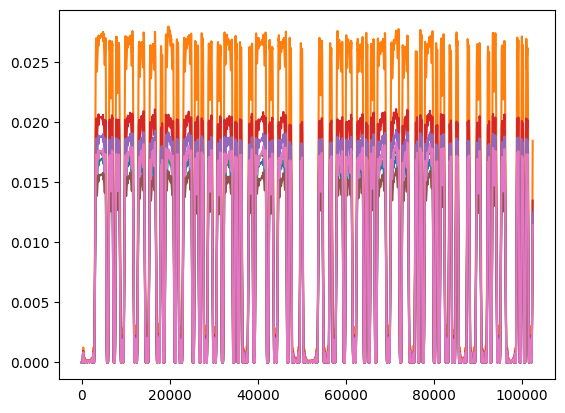

In [2]:
for i in range(7):
    plt.plot(np.abs(results[f"out{i}"]["output"].amplitude[:,1,0])**2)
plt.show()

Best sampling phase = 214 samples  (~2.14 ps) from your trace start


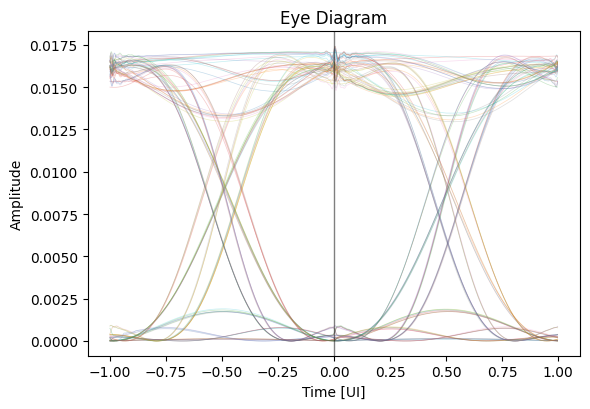

Collected 99 decision samples.


In [4]:
def build_eye_and_best_phase(y, dt, sps, k_ui=2):
    """
    y   : 1D waveform
    dt  : sample period (1e-14 in your case)
    sps : samples per symbol (2000 for your RRC shaping)
    k_ui: window width in unit intervals (2 is standard)
    Returns: (t_ui, M, best_phase, sample_time_offset)
      - t_ui: time axis in UI
      - M:    matrix of shape (num_traces, k_ui*sps) for plotting
      - best_phase: integer [0..sps-1]
      - sample_time_offset: best_phase * dt
    """
    # Sweep phase to maximize "eye opening" at mid-UI:
    # we use variance at the center sample (bigger variance -> crossed transitions align).
    mid = (k_ui * sps) // 2
    best_phase, best_metric = 0, -np.inf

    for p in range(sps):
        seg = y[p:]
        L = (len(seg) // (k_ui * sps)) * (k_ui * sps)
        if L == 0:
            break
        M = seg[:L].reshape(-1, k_ui * sps)
        # metric: variance at center + slope around center (optional combo)
        metric = np.var(M[:, mid])
        if metric > best_metric:
            best_metric = metric
            best_phase = p

    # Build the final eye at that phase
    seg = y[best_phase:]
    L = (len(seg) // (k_ui * sps)) * (k_ui * sps)
    M = seg[:L].reshape(-1, k_ui * sps)
    t_ui = np.linspace(-k_ui/2, +k_ui/2, k_ui * sps, endpoint=False)
    return t_ui, M, best_phase, best_phase * dt

# --- 3) Sample at decision instant --------------------------------------------
def extract_symbol_samples(y, dt, sps, best_phase, k_ui=2):
    """
    Return the samples taken at the middle of each UI after aligning by best_phase.
    """
    seg = y[best_phase:]
    step = sps  # 1 sample per symbol at decision time
    # center of the 2-UI window:
    decision_index = (k_ui * sps) // 2
    # Align windows then take the center sample of each window
    L = (len(seg) // (k_ui * sps)) * (k_ui * sps)
    M = seg[:L].reshape(-1, k_ui * sps)
    samples = M[:, decision_index]
    # Useful for plotting sampling points on original time axis:
    sample_times = (best_phase + decision_index + np.arange(len(samples)) * (k_ui * sps)) * dt
    return samples, sample_times

# --- 4) Use the helpers with YOUR results -------------------------------------
# Pick which port & wavelength you want to analyze:
port_to_view = "out0"       # e.g., an MMI output port
wl_index     = 0          # choose the comb line index you care about
y = jnp.abs(results[port_to_view]["output"].amplitude[:, wl_index])**2

sps = 512     # your shaping setting
dt  = 1e-14    # your sim sample period
t_ui, M, best_phase, phase_time = build_eye_and_best_phase(y, dt, sps, k_ui=2)

print(f"Best sampling phase = {best_phase} samples  (~{phase_time*1e12:.2f} ps) from your trace start")

# Plot the eye and mark the decision instant
plt.figure(figsize=(6,4.2))
plt.plot(t_ui, M.T, lw=0.5, alpha=0.25)
plt.axvline(0.0, color='k', lw=1.0, alpha=0.5)       # decision instant (middle of the 2-UI window)
plt.title("Eye Diagram")
plt.xlabel("Time [UI]"); plt.ylabel("Amplitude")
plt.tight_layout(); plt.show()

# Get the actual symbol samples at the decision instants (for detection/BER)
sym_samples, sample_times = extract_symbol_samples(y, dt, sps, best_phase, k_ui=2)
print(f"Collected {len(sym_samples)} decision samples.")

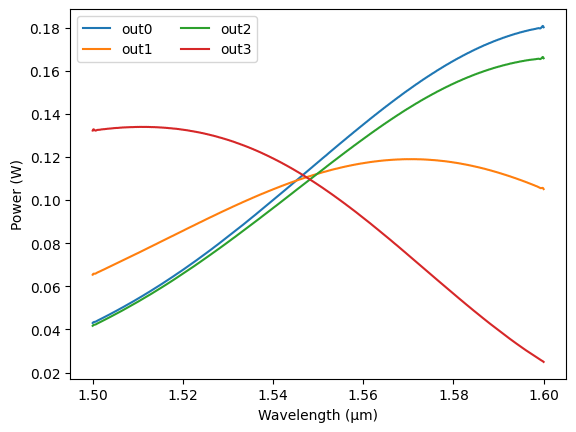

In [5]:
def load_sdict_npz(fname):
        d = np.load(fname)
        wls = d["wavelengths"]
        S = {}
        for k in d.files:
            if k == "wavelengths": continue
            # keys like "S_out3_in5"
            _, to_p, from_p = k.split("_", 2)
            S[(to_p, from_p)] = np.squeeze(d[k])
        return wls, S


w_i, Sp = load_sdict_npz("gm_lumerical_sdict_1p50_1p60um_200pts.npz")
in_key  = "in7"
out_keys = ["out0","out1","out2","out3",]

# |S|^2 * Pin(mW) = Pout(mW); convert to µW
Pin_dBm = -10.2
for ok in out_keys:
    S = Sp[(ok, in_key)]                 
    P_uW = (np.abs(S)**2)    
    plt.plot(w_i, P_uW, label=ok)

plt.xlabel("Wavelength (µm)")
plt.ylabel("Power (W)")
plt.legend(ncol=2)
plt.show()